<a href="https://colab.research.google.com/github/Pravinoraon/capstone/blob/main/Notebook%202%3A%20Model%20Training%20with%20EfficientNetB0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [15]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from google.colab import drive

# Mount Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
# Define dataset paths
train_dir = "/content/drive/MyDrive/bell_pepper_data/train"
val_dir = "/content/drive/MyDrive/bell_pepper_data/val"

# Verify dataset paths
print("Train directory exists:", os.path.exists(train_dir))
print("Validation directory exists:", os.path.exists(val_dir))
print("Train categories:", os.listdir(train_dir) if os.path.exists(train_dir) else "Not found")
print("Validation categories:", os.listdir(val_dir) if os.path.exists(val_dir) else "Not found")


Train directory exists: True
Validation directory exists: True
Train categories: ['Diseased', 'Healthy']
Validation categories: ['Healthy', 'Diseased']


In [17]:
# Define constants
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# Data augmentation for training images
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

# Create train & validation generators
train_data = train_datagen.flow_from_directory(
    train_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)

val_data = val_datagen.flow_from_directory(
    val_dir, target_size=IMG_SIZE, batch_size=BATCH_SIZE, class_mode='binary'
)


Found 1979 images belonging to 2 classes.
Found 496 images belonging to 2 classes.


In [18]:
# Load EfficientNetB0 without top layers
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build custom classifier on top of EfficientNetB0
inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(1, activation='sigmoid')(x)  # ✅ Fixed issue

# Define the model
model = Model(inputs, outputs)

# Compile model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetb0 (Functional)          │ (None, 7, 7, 1280)          │       4,049,571 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 4,213,668 (16.07 MB)

 Trainable params: 164,097 (641.00 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

In [19]:
# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=20,
    callbacks=[early_stopping]
)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 408s 6s/step - accuracy: 0.5995 - loss: 0.6786 - val_accuracy: 0.5968 - val_loss: 0.6750
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.6272 - loss: 0.6710 - val_accuracy: 0.5968 - val_loss: 0.6798
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.5921 - loss: 0.6788 - val_accuracy: 0.5968 - val_loss: 0.6745
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 211s 3s/step - accuracy: 0.6115 - loss: 0.6721 - val_accuracy: 0.5968 - val_loss: 0.6743
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 251s 3s/step - accuracy: 0.5790 - loss: 0.6837 - val_accuracy: 0.5968 - val_loss: 0.6742
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 210s 3s/step - accuracy: 0.6012 - loss: 0.6758 - val_accuracy: 0.5968 - val_loss: 0.6744
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 206s 3s/step - accuracy: 0.6045 - loss: 0.6754 - val_accuracy: 0.5968 - val_loss: 0.6756
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 201s 3s/step - accuracy: 0.6080 - loss: 0.6726 - val_accuracy: 0.5968 - v

In [20]:
# Save trained model
model_save_path = "/content/drive/MyDrive/bell_pepper_data/bell_pepper_disease_model.h5"
model.save(model_save_path)
print(f"Model saved at: {model_save_path}")


Model saved at: /content/drive/MyDrive/bell_pepper_data/bell_pepper_disease_model.h5


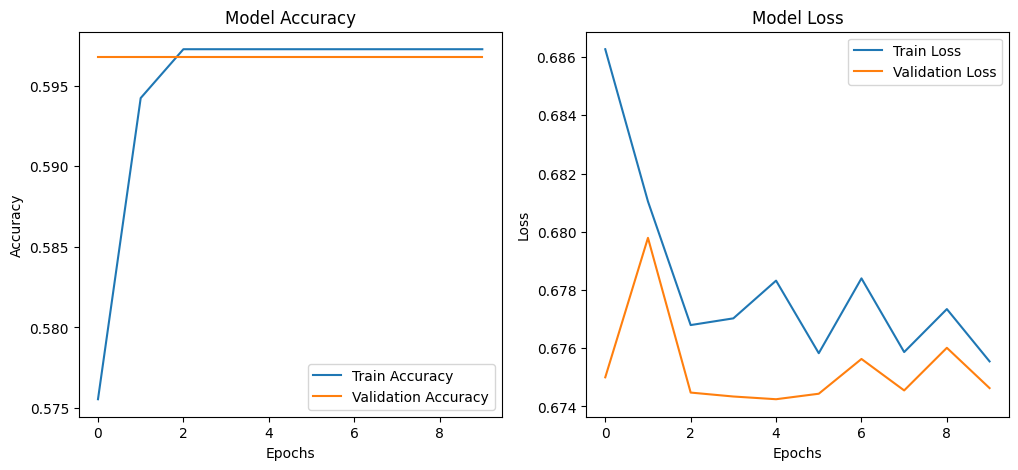

In [21]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()
